# Standard Setup

### Imports 

In [2]:
# Standard things
import math
import numpy as np
import jax.numpy as jnp
import jax

# FLOAT64 seems to be necessary for integral precision
jax.config.update("jax_enable_x64", True)

# Project-specific things
# from utils.function_utils import polynomial, taylor_expand_2d, polynomial_multiply, polynomial_sum, polynomial_power, print_polynomial
# from utils.function_utils import integrate_taylor_polynomial, derivative_t_polynomial, taylor_expand_2d, matching_coeffs
# from utils.distribution_utils import construct_pdf, construct_cdf

from utils.function_utils import polynomial, taylor_expand_2d, polynomial_multiply, polynomial_sum, polynomial_power, print_polynomial
from utils.function_utils import integrate_taylor_polynomial, derivative_t_polynomial, taylor_expand_2d, matching_coeffs, build_powers
from utils.distribution_utils import q, log_q

from utils.qcd_utils import running_coupling   
from jax.experimental.ode import odeint

# Plot
import matplotlib.pyplot as plt
from rikabplotlib.plot_utils import newplot, hist_with_errors


### Jax setting and compilation

In [3]:
# JAX vmapping and compilation
jitted_q  = jax.jit(q)
vmapped_q = jax.vmap(jitted_q, in_axes=(0, None, None, None))

jitted_log_q  = jax.jit(log_q)
vmapped_log_q = jax.vmap(jitted_log_q, in_axes=(0, None, None, None))

jitted_polynomial = jax.jit(polynomial)
vmapped_polynomial = jax.vmap(jitted_polynomial, in_axes=(0, None))

# Problem Setup

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


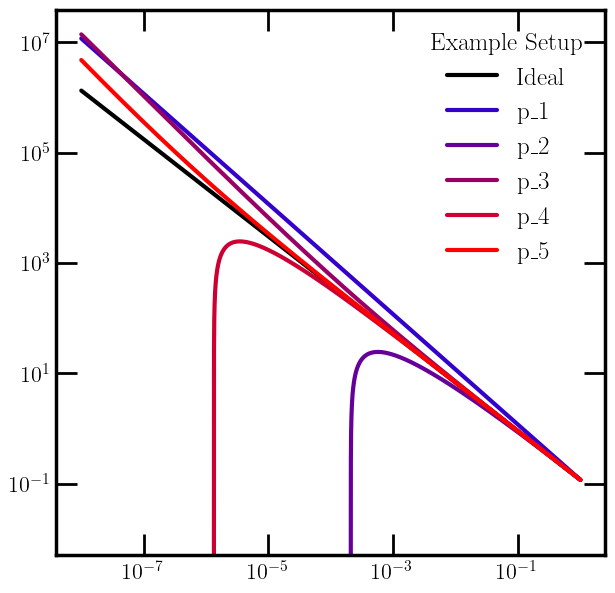

In [4]:
max_order = 5
num_trials = 50
extra_orders = 1

ALT_DATASET = True



# Problem-dependent functions 
def t_from_x(x):
    return jnp.log(1/x)

def x_from_t(t):
    return jnp.exp(-t)



def exponential_distribution(t, alpha, params):
    return alpha  * jnp.exp(-alpha * t)


def p_order_N(t, alpha, M):

    result = jnp.zeros_like(t)
    for i in range(M ):
        result += alpha * jnp.power(-1 * alpha * t , i) / math.factorial(i)
    return result


# Colormap setup
colors = [0]
for order in range(1,max_order+1):

    o = (order) / (max_order)
    colors.append((o, 0, 1 - o))


# Plot
xs = jnp.logspace(-8, 0, 10000)

fig, ax = newplot("full")
ax.plot(xs, exponential_distribution(t_from_x(xs) , 0.118, None) / xs, label="Ideal", color = "black")
for order in range(1,max_order+1):
    ax.plot(xs, p_order_N(t_from_x(xs), 0.118, order) / xs, label=f"p_{order}", color = colors[order])

ax.set_xscale("log")
ax.set_yscale("log")

plt.legend(title = "Example Setup")





### Alternate Problem: Angularity-like

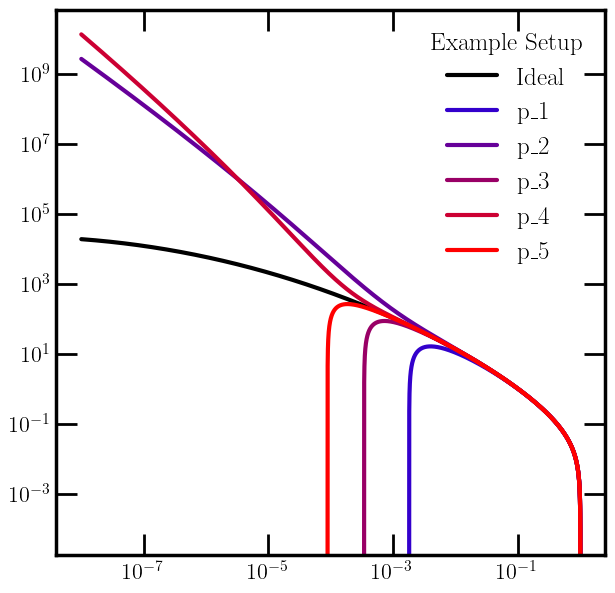

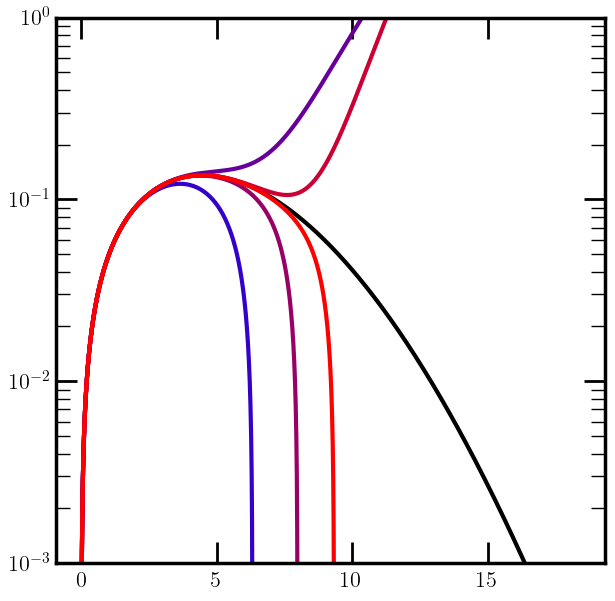

In [5]:

if ALT_DATASET:

    def exponential_distribution(t, alpha, params):

        # scale = 91.1876 * x_from_t(t)
        # L = jnp.log(scale / mz)
        # alpha_bar = running_coupling(alpha, mz, scale)

        alpha_bar = alpha * 4/3 / jnp.pi

        beta_0 = (11 * 3 - 2 * 5) / (12 * jnp.pi)

        # integral = jnp.log( 1 - 2 * alpha_bar * jnp.pi / 4 * 3 * beta_0 * L) / (2 * beta_0)
        integral = alpha_bar * t * t / 2

        return alpha_bar * t * jnp.exp(-integral) 


    def p_order_N(t, alpha, M):

        # scale = 91.1876 * x_from_t(t)
        # alpha_bar = running_coupling(alpha, mz, scale)


        result = 0
        alpha_bar = alpha * 4/3 / jnp.pi
        for i in range(M + 1):
            result += alpha_bar * t * jnp.power(-1 * alpha_bar * t **2 / 2, i) / math.factorial(i)
        return result


    # Plot
    xs = jnp.logspace(-8, 0, 10000)

    fig, ax = newplot("full")
    ax.plot(xs, exponential_distribution(t_from_x(xs) , 0.118, None) / xs, label="Ideal", color = "black")
    for order in range(1,max_order+1):
        ax.plot(xs, p_order_N(t_from_x(xs), 0.118, order) / xs, label=f"p_{order}", color = colors[order])

    ax.set_xscale("log")
    ax.set_yscale("log")

    plt.legend(title = "Example Setup")

    fig, ax = newplot("full")
    ax.plot(t_from_x(xs), exponential_distribution(t_from_x(xs) , 0.118, None), label="Ideal", color = "black")
    for order in range(1,max_order+1):
        ax.plot(t_from_x(xs), p_order_N(t_from_x(xs), 0.118, order), label=f"p_{order}", color = colors[order])

    # ax.set_xscale("log")
    ax.set_yscale("log")
    plt.ylim(1e-3, 1)


# Matching

In [14]:
t = jnp.linspace(0, 10, 1000)
xs = x_from_t(t)



# Array to save curves for plotting
data = np.zeros((max_order, t.shape[0], num_trials))

for order in range(1, max_order):

    def p_temp(t, alpha, params):
        return p_order_N(t, alpha, order)


    m_order = order
    n_order = 1 * order

    # Normalization array, size includes extra orders
    factorials = np.zeros((m_order + 1 + extra_orders, n_order + 1 + extra_orders))
    for i in range(factorials.shape[0]):
        for j in range(factorials.shape[1]):
            factorials[i, j] = (i+1) # math.factorial(i) #* math.factorial(j)


    # Actually perform the matching
    print("Order: ", order)
    g_mn_matched, g_star = matching_coeffs(p_temp, m_order, n_order)


    for trial in range(num_trials):


        # Get a random seed
        seed = jax.random.PRNGKey(trial * 1000 + order * 100) 

        # print(g_mn_matched)
        # print(g_star)
    
        # Prior on the g_mn
        std = 10 / factorials
        g_mn = (2 * (jax.random.uniform(seed, factorials.shape))-1)   * std# - (std / 2)
        max_m = g_mn.shape[0]
        max_n = g_mn.shape[1]


        # set the highest order term to be negative
        g_mn = g_mn.at[order+1:max_m, max_n-1].set(-jnp.abs(g_mn[order+1:max_m, max_n-1]))

        # Set the coefficients of the random array to be the matched ones
        g_mn = g_mn.at[:m_order+1, :].set(0)
        g_mn = g_mn.at[:m_order+1, :n_order+1].set(g_mn_matched)


        # Save the curve
        data[order, :, trial] = jnp.nan_to_num(vmapped_q(t, 0.118, g_star, g_mn))



Order:  1
Order:  2
Order:  3
Order:  4


### Plots

Order 1
12.142344414527722
21.782144174324703
3.547831115072701
2.4427036841975176
4.371050645260672
2.1347155660077224
22.700492291043798
3.5232271138421103
24.915977437408632
6.277894894741703
8.557513143642034
24.405739732689987
23.06466547380404
10.208198848896181
2.9901573946247657
26.123504292670976
21.28815692499054
4.078044174333819
20.09843530349042
44.460292758185645
27.906644893059315
2.2044119925873638
4.6125360731877745
4.599422720025647
57.46986435697452
12.460036543086973
2.3095640089218485
12.0434360767984
11.082399216636492
11.60629996516544
12.80015947408674
3.6502627747825525
28.163179965891572
13.573564860897601
40.32693540157173
5.959420848803882
11.554258082955231
7.755300497500723
6.458983345320743
5.710837188992022
3.220498400927376
20.051311290567913
9.11795040998354
17.696311621787405
7.454190880807854
5.4416204145270015
21.985953739879665
20.59324336931973
4.395193179281107
10.728467826791897
Order 2
1.1278307867463995
1.315880824969438
4.406038347969119
1.41

(0.9090909090909091, 1.1)

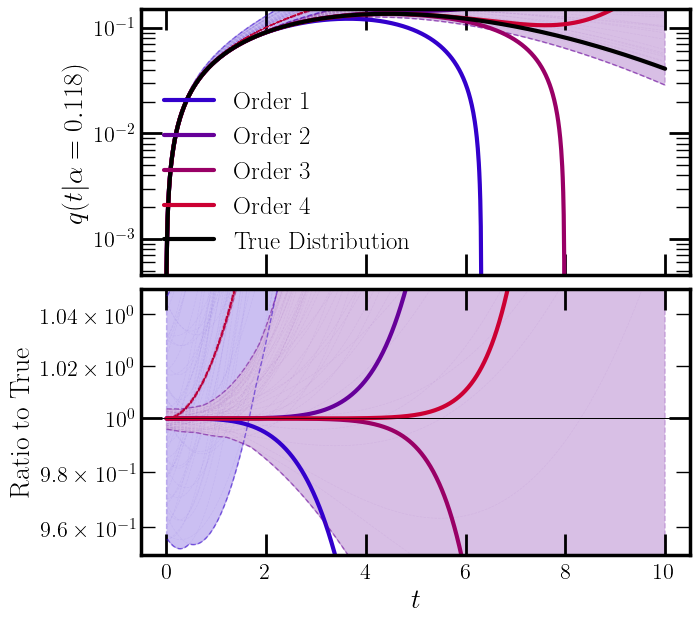

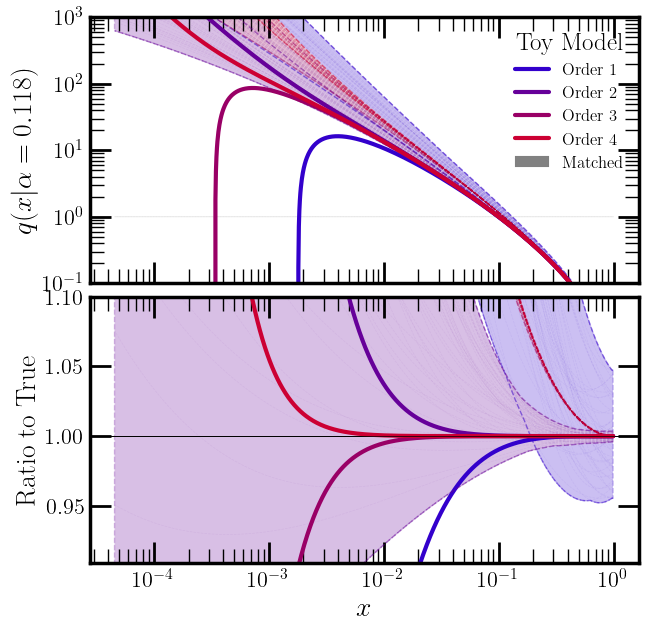

In [15]:
fig, ax = newplot("full", subplot_array=(2, 1), sharex=True)




for order in range(1, max_order):
    ax[0].plot(t, p_order_N(t, 0.118, order), label=f"Order {order}", color = colors[order],)



    for trial in range(num_trials):

        ax[0].plot(t, data[order, :,trial], color = colors[order], linestyle = "--", alpha = 0.05, lw = 0.5)
        ax[1].plot(t, data[order, :,trial] / exponential_distribution(t, 0.118, None), color = colors[order], linestyle = "--", alpha = 0.05, lw = 0.5)



    mean = np.nanmean(data[order], axis = 1)
    # std = np.nanstd(data[order], axis = 1)
    plus = np.nanmax(data[order], axis = 1)
    minus = np.nanmin(data[order], axis = 1)

    # plt.plot(t, mean, color = colors[order], linestyle = "--", label = f"Order {order} Mean")
    ax[0].plot(t, minus, color = colors[order], linestyle = "--", alpha = 0.5, lw = 1)
    ax[0].plot(t, plus, color = colors[order], linestyle = "--", alpha = 0.5, lw = 1)
    ax[0].fill_between(t, minus, plus, color = "white", alpha = 0.99, ls = "--")
    ax[0].fill_between(t, minus, plus, color = colors[order], alpha = 0.25, ls = "--")
    # ax[0].plot(t, mean, color = colors[order], linestyle = "--")
    

    # ax[1].plot(t, mean / exponential_distribution(t, 0.118, None), color = colors[order], linestyle = "--")
    ax[1].plot(t, (minus) / exponential_distribution(t, 0.118, None), color = colors[order], linestyle = "--", alpha = 0.5, lw = 1)
    ax[1].plot(t, (plus) / exponential_distribution(t, 0.118, None), color = colors[order], linestyle = "--", alpha = 0.5, lw = 1)
    ax[1].fill_between(t, (minus) / exponential_distribution(t, 0.118, None), (plus) / exponential_distribution(t, 0.118, None), color = "white", alpha = 0.99, ls = "--")
    ax[1].fill_between(t, (minus) / exponential_distribution(t, 0.118, None), (plus) / exponential_distribution(t, 0.118, None), color = colors[order], alpha = 0.25, ls = "--")
    

    ax[1].plot(t, p_order_N(t, 0.118, order) / exponential_distribution(t, 0.118, None), color = colors[order],)
    ax[1].axhline(1, color = "black", linestyle = "-", lw = 0.5)

ax[0].plot(t, exponential_distribution(t, 0.118, None), label="True Distribution", color = "Black")


ax[0].legend(loc = "lower left")

ax[0].set_yscale("log")
ax[1].set_yscale("log")

ax[1].set_xlabel(r"$t$")
ax[0].set_ylabel(r"$q(t|\alpha = 0.118)$")
ax[1].set_ylabel("Ratio to True")

# Decrease margin between subplots
plt.subplots_adjust(hspace = 0.05)

max_y = 1.1 * np.max(exponential_distribution(t[1:], 0.118, None))
min_y = 0.9 * np.min(exponential_distribution(t[1:], 0.118, None))
ax[0].set_ylim(min_y, max_y)
ax[1].set_ylim(0.95, 1.05)






# ######################### X version #########################

fig, ax = newplot("full", subplot_array=(2, 1), sharex=True)

xs = x_from_t(t)


# set ax[0] to take up the whole space

for order in range(1, max_order):

    print("Order" , order)

    ax[0].plot(xs, p_order_N(t, 0.118, order) / xs, label=f"Order {order}", color = colors[order],)



    for trial in range(num_trials):

        ax[0].plot(xs, data[order, :,trial] / xs , color = colors[order], linestyle = "--", alpha = 0.05, lw = 0.5)
        ax[1].plot(xs, data[order, :,trial] / exponential_distribution(t, 0.118, None) , color = colors[order], linestyle = "--", alpha = 0.05, lw = 0.5)

        integral = jnp.trapz(data[order, :,trial], t)
        # print(data[order, :,trial])
        print(integral)



    mean = np.nanmean(data[order], axis = 1) / xs
    plus = np.nanmax(data[order], axis = 1) / xs
    minus = np.nanmin(data[order], axis = 1) / xs


    std = np.nanstd(data[order], axis = 1) / xs

    # plt.plot(t, mean, color = colors[order], linestyle = "--", label = f"Order {order} Mean")
    ax[0].plot(xs, plus, color = colors[order], linestyle = "--", alpha = 0.5, lw = 1)
    ax[0].plot(xs, minus, color = colors[order], linestyle = "--", alpha = 0.5, lw = 1)
    ax[0].fill_between(xs, minus, plus, color = "white", alpha = 0.99, ls = "--")
    ax[0].fill_between(xs, minus, plus, color = colors[order], alpha = 0.25, ls = "--")
    # ax[0].plot(t, mean, color = colors[order], linestyle = "--")
    

    # ax[1].plot(t, mean / exponential_distribution(t, 0.118, None), color = colors[order], linestyle = "--")
    ax[1].plot(xs, (minus) / exponential_distribution(t, 0.118, None)* xs, color = colors[order], linestyle = "--", alpha = 0.5, lw = 1)
    ax[1].plot(xs, (plus) / exponential_distribution(t, 0.118, None)* xs, color = colors[order], linestyle = "--", alpha = 0.5, lw = 1)
    ax[1].fill_between(xs, (minus) / exponential_distribution(t, 0.118, None) * xs, (plus) / exponential_distribution(t, 0.118, None)* xs, color = "white", alpha = 0.99, ls = "--")
    ax[1].fill_between(xs, (minus) / exponential_distribution(t, 0.118, None)* xs, (plus) / exponential_distribution(t, 0.118, None)* xs, color = colors[order], alpha = 0.25, ls = "--")


    ax[1].plot(xs, p_order_N(t, 0.118, order) / exponential_distribution(t, 0.118, None), color = colors[order],)
    ax[1].axhline(1, color = "black", linestyle = "-", lw = 0.5)

# ax[0].plot(xs, exponential_distribution(t, 0.118, None)/ xs, label="True", color = "Black")

# Add shaded to legend
ax[0].fill_between(xs, np.ones_like(xs), np.ones_like(xs), color = "grey", alpha = 0.99, ls = "--", label = "Matched", lw = 0.1)


ax[0].legend(loc = "upper right", fontsize = 12, title = "Toy Model")

ax[0].set_yscale("log")
# ax[1].set_yscale("log")
ax[0].set_xscale("log")

ax[1].set_xlabel(r"$x$")
ax[0].set_ylabel(r"$q(x|\alpha = 0.118)$")
ax[1].set_ylabel("Ratio to True")

# Decrease margin between subplots
plt.subplots_adjust(hspace = 0.05)

ax[0].set_ylim(1e-1, 1e3)
ax[1].set_ylim(1/1.1, 1.1)

# fig.delaxes(ax[1])
# # set ax[0] height 
# fig.set_figheight(12)

# Parameter Extraction

### Define the Dataset

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Mean of samples: 5.658096105551793


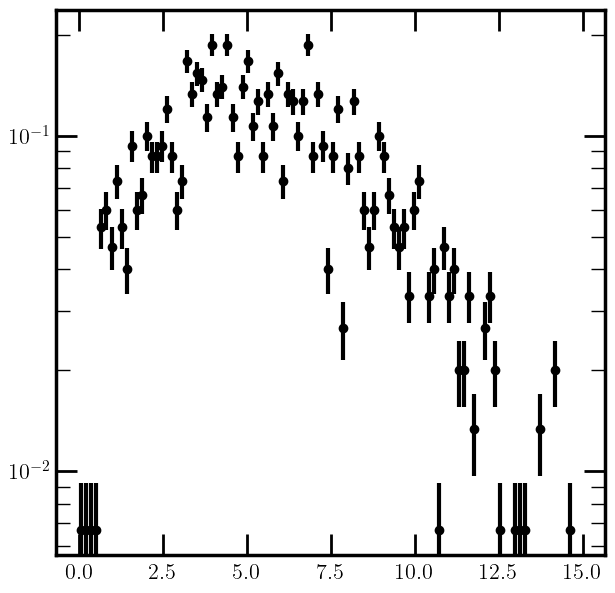

In [8]:
N_data = 1000
alpha_true = 0.118
t_max = 60

# Sample an exponential distribution
seed = jax.random.PRNGKey(0)
t_data = jax.random.exponential(seed, (N_data,)) / alpha_true





# ########## Alternate Dataset ##########

def sample_from_rayleigh(seed, alpha, shape=(1,)):

    alpha_bar = alpha * 4/3 / jnp.pi
    u = jax.random.uniform(seed, shape=shape)
    scale = 1.0 / jnp.sqrt(alpha_bar)
    t = scale * jnp.sqrt(-2.0 * jnp.log(u))
    return t

# Usage:
if ALT_DATASET:
    seed = jax.random.PRNGKey(0)
    t_data = sample_from_rayleigh(seed, alpha_true, shape=(N_data,))
    t_max = 15
    print("Mean of samples:", jnp.mean(t_data))





fig, ax = newplot("full")
bins = 100
counts, bins = np.histogram(t_data, bins = 100, range = [0, t_max], density = True)
bin_centers = (bins[1:] + bins[:-1]) / 2
plt.errorbar(bin_centers, counts, yerr = np.sqrt(counts / N_data), fmt = "o", color = "black",)

plt.legend()

plt.yscale("log")

### Attempt MLE with the Fixed Order

Text(0, 0.5, '$-2 \\log L(\\alpha)$')

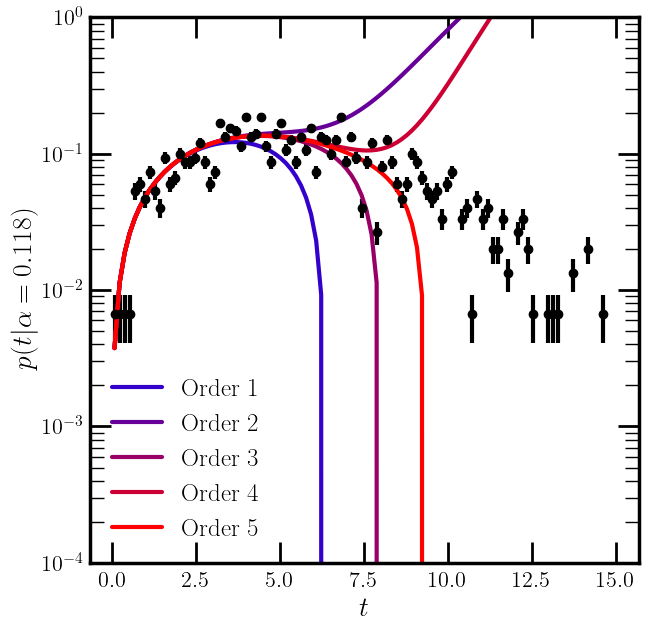

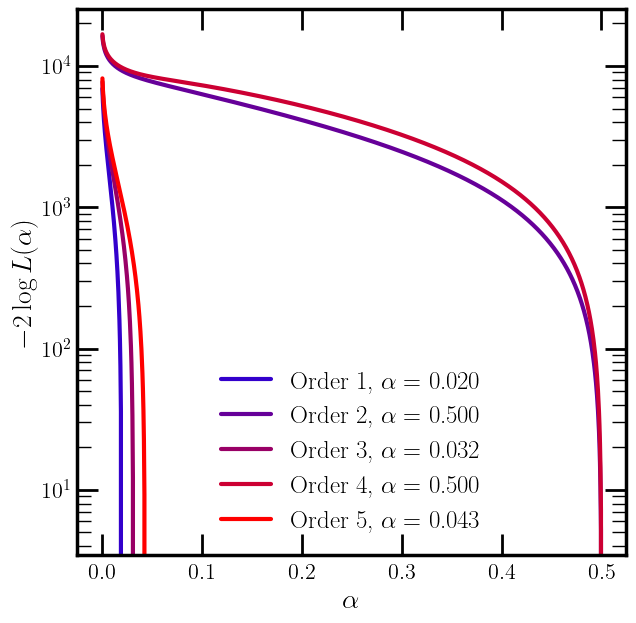

In [9]:
# Get lambda functions for FO likelihoods




max_M = 5


fig, ax = newplot("full")
bins = 100
counts, bins = np.histogram(t_data, bins = 100, range = [0, t_max], density = True)
bin_centers = (bins[1:] + bins[:-1]) / 2
plt.errorbar(bin_centers, counts, yerr = np.sqrt(counts / N_data), fmt = "o", color = "black",)


for i in range(1, max_M + 1):

    color = (i / max_M, 0, 1 - i / max_M)

    res = (lambda x : p_order_N(bin_centers, x, i))(0.118)
    ax.plot(bin_centers, res, label = f"Order {i}", color = color)
plt.yscale("log")

plt.xlabel(r"$t$")
plt.ylabel(r"$p(t|\alpha = 0.118)$")

plt.ylim(1e-4, 1e0)

plt.legend()


fig, ax = newplot("full")                                                                       
for i in range(1, max_M + 1):

    color = (i / max_M, 0, 1 - i / max_M)


    vmapped_p_order_N = jax.vmap(p_order_N, in_axes=(0, None, None))
    t_sorted = jnp.sort(t_data)
    t_sorted = t_sorted


    def likelihood_function(alpha):

        likelihoods = -2 * jnp.log(vmapped_p_order_N(t_sorted, alpha, i))
        cumulative_sum = jnp.cumsum(likelihoods)

        # return jnp.nanmin(cumulative_sum)
        return cumulative_sum[-1]
    


    vmapped_likelihood_function = jax.vmap(likelihood_function)
    alphas = jnp.linspace(0.00, 0.5, 1000)
    likelihoods = vmapped_likelihood_function(alphas)

    best_alpha = alphas[jnp.nanargmin(likelihoods, axis = 0)]  
    best_likelihood = likelihood_function(best_alpha)

    likelihoods = likelihoods - best_likelihood



    # best_alpha = alphas[jnp.argmin(likelihoods, axis = 0)]
    # ax.plot(t_sorted, best_alpha, label = f"Order {i}")
    
    ax.plot(alphas, likelihoods, label = f"Order {i}, " + r"$\alpha = $" +  f"{best_alpha : .3f}", color = color)

plt.legend()
plt.yscale("log")

plt.xlabel(r"$\alpha$")
plt.ylabel(r"$-2 \log L(\alpha)$")


Order 1
Full Min -2628482.4825326856
Full Alpha 0.2
Full Coeffs [  -39.9999514   -226.32382204 -1605.44498962]


101it [00:38,  2.62it/s]


Order 1
Min Alpha 0.199
Range 0.2 0.2
Coeffs [  -40.00000513  -226.32390447 -1605.44499405]
Order 2
Full Min -6945194.323860653
Full Alpha 0.2
Full Coeffs [ -272.17169875   105.57329623  -179.43156275 -2613.99420116]


101it [00:53,  1.88it/s]


Order 2
Min Alpha 0.199
Range 0.2 0.2
Coeffs [   -7.99996708   -45.26474166  -321.08902463 -2637.87058108]
Order 3
Full Min -14021859.891212523
Full Alpha 0.1999999999999973
Full Coeffs [-2143.11125453  -271.71751893  1006.77682775  -402.38676523
 -2907.40627381]


101it [01:49,  1.08s/it]


Order 3
Min Alpha 0.199
Range 0.2 0.2
Coeffs [-1.60000690e+00 -9.05298221e+00 -6.42177294e+01 -5.27574183e+02
 -4.81733333e+03]
Order 4
Full Min -75947461.12524706
Full Alpha 0.1999999999999993
Full Coeffs [-1456.37207188 -2231.7251111  -1730.37277145  -424.32056769
 -2519.14085489 -7702.0753456 ]


101it [02:49,  1.68s/it]


Order 4
Min Alpha 0.199
Range 0.2 0.2
Coeffs [-3.02956851e-04 -1.81057239e+00 -1.28435356e+01 -1.05514847e+02
 -9.63466654e+02 -9.53577428e+03]
Order 5
Full Min -197136478.42587158
Full Alpha 0.19999998906154948
Full Coeffs [ 4511.50587715  3441.82358788  -496.4243587   7078.82240457
  1736.18708784 -4898.86561269 -9356.76312857]


101it [03:35,  2.14s/it]

Order 5
Min Alpha 0.199
Range 0.2 0.2
Coeffs [-2.49858733e-07 -1.22819306e-04 -2.51339464e+00 -2.10743550e+01
 -1.92698854e+02 -1.90715442e+03 -2.01212350e+04]


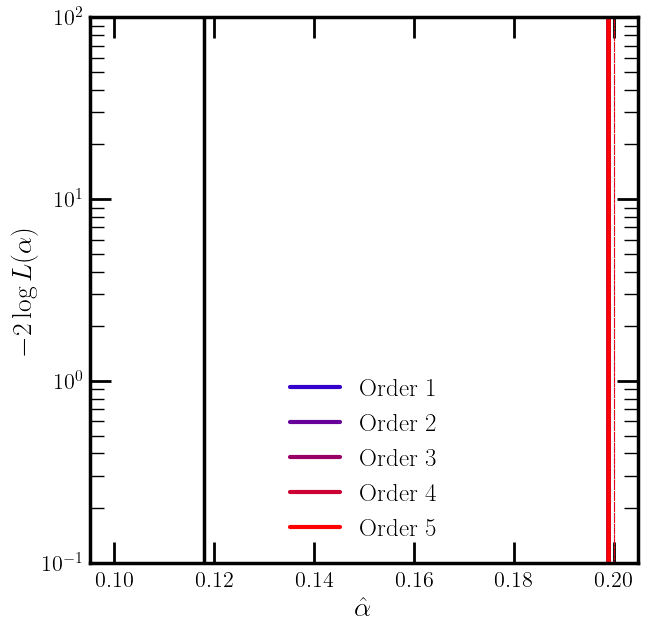

In [17]:
from scipy.optimize import minimize
from tqdm import tqdm

# Only 1 higher order term works for now
num_higher_orders = 1

# highest order to try
max_M = 5


fig, ax = newplot("full")           

alpha_low = 0.1
alpha_high = 0.2
num_alpha_points = 101
std = 10.0

likelihood_data = np.zeros((max_M, num_alpha_points))
g_mn_data = []


def log_prior(g_mn_higer, m, alpha):

    beta0 = 11/3*3 - 5 * 2/3 
    std = 1 #10*(alpha * jnp.log(2) * beta0 / (2 * jnp.pi))**m

    # treat the higher order terms as a gaussian prior
    return jnp.sum(jnp.log(jax.scipy.stats.norm.pdf(g_mn_higer, 0, std)))


for i in range(1,max_M + 1):

    g_mn_data_i = []

    # Initialize g_mn by matching the low order stuff
    g_mn_matched, g_star = matching_coeffs(exponential_distribution, i, i)
    g_mn = jnp.zeros((g_mn_matched.shape[0]+num_higher_orders, g_mn_matched.shape[1]+num_higher_orders))
    g_mn = g_mn.at[:i+1, :i+1].set(g_mn_matched)

    # We can only change parameters after the matched order in alpha
    non_frozen_params_mask = jnp.zeros((g_mn_matched.shape[0]+num_higher_orders, g_mn_matched.shape[1]+num_higher_orders), dtype = bool)
    non_frozen_params_mask = non_frozen_params_mask.at[i+1:, :].set(True)

    # Data cutoff
    masked_data = t_data

    # Likelihood function, params[0] = alpha, params[1:] = higher order g_mn
    @jax.jit
    def likelihood_function(params):

        alpha = params[0]
        g_mn_higher = params[1:]
        highest_order = g_mn_higher.shape[0]

        # Set g so that the lower order terms are matched and the higher order terms are the ones we are varying
        g_mn = jnp.zeros((g_mn_matched.shape[0]+num_higher_orders, g_mn_matched.shape[1]+num_higher_orders))
        g_mn = g_mn.at[i+1:, :].set(g_mn_higher)
        g_mn = g_mn.at[:i+1, :i+1].set(g_mn_matched)

        L =  -2 * jnp.sum((vmapped_log_q(masked_data, alpha, g_star, g_mn)))
        L = L - 2*log_prior(g_mn_higher, highest_order, alpha)
        return L
    
    # Profile likelihood whe alpha is a parameter and g_mn_higher is varied
    @jax.jit
    def profile_likelihood_function(g_mn_higher, alpha):


        g_mn = jnp.zeros((g_mn_matched.shape[0]+num_higher_orders, g_mn_matched.shape[1]+num_higher_orders))
        g_mn = g_mn.at[i+1:, :].set(g_mn_higher)
        g_mn = g_mn.at[:i+1, :i+1].set(g_mn_matched)
        highest_order = g_mn_higher.shape[0]

        L =  -2 * jnp.sum((vmapped_log_q(masked_data, alpha, g_star, g_mn)))
        L = L - 2*log_prior(g_mn_higher, highest_order, alpha)
        return L
    

    ###### Minimize likelihood function #####
    # This is the denominator of the profile likelihood ratio

    # Initial guess: alpha = 0.118, g_mn = 0
    initial_alpha = 0.118
    initial_guess = jnp.zeros(g_mn.shape[1]+1)
    initial_guess = initial_guess.at[0].set(initial_alpha)

    # Minimize the full likelihood to et the best alpha and g_mn
    bounds = [(alpha_low, alpha_high)] + [(None, None)] * g_mn.shape[1]
    res_full = minimize(likelihood_function, initial_guess, method='Nelder-Mead', options={'disp': False}, bounds = bounds)

    print("Order", i)
    print("Full Min", res_full.fun)
    print("Full Alpha", res_full.x[0])
    print("Full Coeffs", res_full.x[1:])


    ###### Minimize profile likelihood function #####

    # Scan over alpha
    central_alpha = res_full.x[0]
    alphas = jnp.linspace(alpha_low, alpha_high , num_alpha_points)

    # Minimize for each alpha, using the g_mn from the full minimization as a starting point
    def profile_minimize(alphas, next_x):


        # o = profile_likelihood_function(jnp.zeros_like(next_x), alphas)
        # return o, next_x

        res_partial = minimize(profile_likelihood_function, next_x, args=(alphas), method='Nelder-Mead', options={'disp': False, 'maxiter': 1000})
        
        # print(alphas, res_partial.fun, res_partial.x)
        return res_partial.fun, res_partial.x

    likelihoods = jnp.zeros(alphas.shape)
    next_x = res_full.x[1:]
    for j, alpha in tqdm(enumerate(alphas)):
        res_partial, next_x = profile_minimize(alpha, next_x)
        likelihoods = likelihoods.at[j].set(res_partial)
        g_mn_data_i.append(next_x)

    # Subtract the minimum of the full likelihood. Should now have a min of zero
    likelihoods = likelihoods - jnp.min(likelihoods)

    # Save the likelihoods
    likelihood_data[i-1] = likelihoods
    g_mn_data.append(g_mn_data_i)

    # Plot
    ax.plot(alphas, likelihoods, label = f"Order {i}", color = colors[i])

    # Get the alphas where the likelihood is within 1 of the minimum
    min_alpha = alphas[jnp.argmin(likelihoods[:-1])]
    ax.axvline(min_alpha, linestyle = "--", lw = 1.5, color = colors[i])


    # Try to get the +- likelihood band
    where_less_than_one = jnp.where(likelihoods < 1)
    alphas_less_than_one = alphas[where_less_than_one]


    print("Order", i)
    print("Min Alpha", min_alpha)

    try:
        minus_one = alphas_less_than_one[0]
        plus_one = alphas_less_than_one[-2]

        # Vertical band
        ax.axvline(minus_one, linestyle = "--", lw = 0.5, color = colors[i])
        ax.axvline(plus_one, linestyle = "--", lw = 0.5, color = colors[i])
        ax.axvspan(minus_one, plus_one, alpha=0.95, color="white")
        ax.axvspan(minus_one, plus_one, alpha=0.1, color=colors[i])
        print("Range", minus_one, plus_one)

    except:
        print("No range found")

    
    print("Coeffs", g_mn_data_i[-1])

    # print("Range", minus_one, plus_one)

    
    # vmapped_likelihood_function = jax.vmap(likelihood_function)
    # alphas = jnp.linspace(0.00, 1.0, 100)
    # likelihoods = vmapped_likelihood_function(alphas)
    

    # min_alpha = alphas[jnp.argmin(likelihoods)]

    # ax.plot(alphas, likelihoods, label = f"Order {i}", color = f"C{i}")
    # ax.axvline(min_alpha, linestyle = "--", lw = 0.5, color = f"C{i}")

ax.axvline(0.118, linestyle = "-", lw = 2.5, color = "black", zorder = 10)

plt.yscale("log")

plt.xlabel(r"$\hat{\alpha}$")
plt.ylabel(r"$-2 \log L(\alpha)$")
plt.ylim(1e-1, 1e2)
plt.legend()

# Test Debugging


@ Radha, this is unimportant.


IndexError: Too many indices for array: 2 non-None/Ellipsis indices for dim 1.

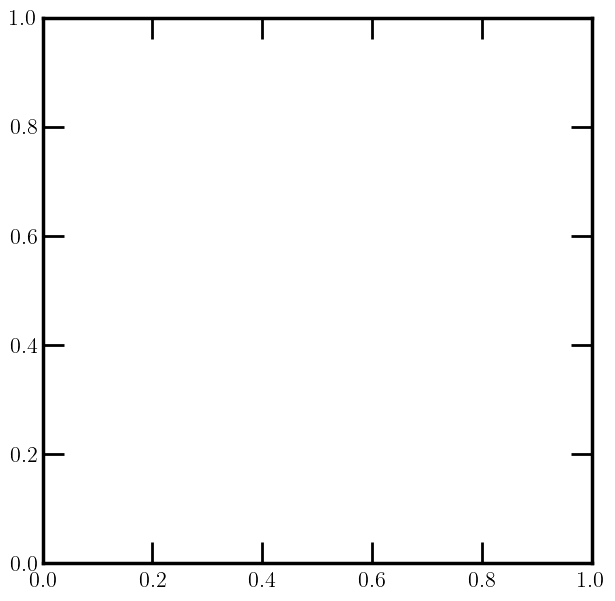

In [ ]:
from scipy.optimize import minimize
from tqdm import tqdm


plot_xs = False

ts = jnp.linspace(0, t_max, 1000)
xs = x_from_t(ts)


fig, ax = newplot("full")                                                                       
for i in range(1,max_M + 1):


    
    g_mn_matched, g_star = matching_coeffs(exponential_distribution, i, i)
    g_mn = jnp.zeros((g_mn_matched.shape[0]+num_higher_orders, g_mn_matched.shape[1]+num_higher_orders))

    g_mn = g_mn.at[:i+1, :i+1].set(g_mn_matched)
    alphas = jnp.linspace(alpha_low, alpha_high, num_alpha_points)

    for trial in range(num_trials):

        g_mn_higher = g_mn_data[i-1][trial]
        g_mn = g_mn.at[i+1:, :].set(g_mn_higher)

        likelihood = likelihood_data[i-1][trial]
        p_val = np.exp(-likelihood  )

        data0 = vmapped_q(ts, alphas[trial], g_star, g_mn)
     
        if plot_xs:
            ax.plot(xs, data0 / xs, color = colors[i], linestyle = "-", alpha = p_val, lw = 1.5)
        else:
            ax.plot(ts[1:], data0[1:], color = colors[i], linestyle = "-", alpha = p_val, lw = 1.5)





#     # We can only change parameters after the matched order in alpha
#     non_frozen_params_mask = jnp.zeros((g_mn_matched.shape[0]+num_higher_orders, g_mn_matched.shape[1]+num_higher_orders), dtype = bool)
#     non_frozen_params_mask = non_frozen_params_mask.at[i+1:, :].set(True)

#     masked_data = t_data[t_data < 30]

#     @jax.jit
#     def likelihood_function(params):

#         alpha = params[0]
#         g_mn_higher = params[1:]

#         g_mn = jnp.zeros((g_mn_matched.shape[0]+num_higher_orders, g_mn_matched.shape[1]+num_higher_orders))

#         # print("")
#         # print(g_mn_matched.shape)
#         # print(g_mn.shape)
#         # print(g_mn_higher.shape)

#         g_mn = g_mn.at[:i+1, :i+1].set(g_mn_matched)
#         g_mn = g_mn.at[i+1:, :].set(g_mn_higher)


#         return -2 * jnp.nansum((log_q(masked_data, alpha, g_star, g_mn)))
    

#     # Minimize likelihood function
#     initial_alpha = 0.118
#     initial_guess = jnp.zeros(g_mn.shape[1]+1)
#     initial_guess = initial_guess.at[1:].set(-0.0000 / i )

#     initial_guess = initial_guess.at[0].set(initial_alpha)


#     res_full = minimize(likelihood_function, initial_guess, method='Nelder-Mead', options={'disp': False})

#     print("Order", i)
#     print("Full Min", res_full.fun)
#     print("Full Alpha", res_full.x[0])
#     print("Full Coeffs", res_full.x[1:])
#     print("Likelihood", -2 * jnp.sum(jnp.log(q(t_data, 0.118, g_star, g_mn_matched))))

#     alpha = 0.118

#     ts = jnp.linspace(0, 50, 1000)
#     g_mn = g_mn.at[:i+1, :].set(0.0)
#     data0 = q(ts, alpha, g_star, g_mn)

#     g_mn = g_mn.at[i+1:, :].set(res_full.x[1:])
#     data1 = q(ts, alpha, g_star, g_mn)

#     ax.plot(ts, data0, label = f"Order {i}", color = colors[i], linestyle = "-")
#     ax.plot(ts, data1, label = f"Order {i} Matched", color = colors[i], linestyle = "--")

# ax.axvline(0.118, linestyle = "--", lw = 0.5, color = "black")

if plot_xs:
    plt.xlabel(r"$x$")
    plt.ylabel(r"$q(x|\alpha)$")
    x_bins = x_from_t(bin_centers)
    plt.errorbar(x_from_t(bin_centers), counts / x_bins, yerr = np.sqrt(counts / N_data) / x_bins, fmt = "o", color = "black",)

    plt.ylim(1e-3, 1e3)
    plt.xscale("log")

else:
    plt.xlabel(r"$t$")
    plt.ylabel(r"$q(t|\alpha)$")


    plt.ylim(1e-4, 5e-1)
    plt.errorbar(bin_centers, counts, yerr = np.sqrt(counts / N_data), fmt = "o", color = "black",)

    plt.plot(ts, exponential_distribution(ts, 0.118, None), label="True Distribution", color = "black", linestyle = "--")

plt.yscale("log")
plt.legend()

